In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2
import random
from datetime import datetime
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose



from tqdm import tqdm
from pathlib import Path

from skimage.morphology import label

In [3]:
BATCH_SIZE=16

In [4]:
# Make filepaths
ship_dir = r'../../airbus-dataset/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test')

# Training Framework

Most of this is taken from [here](https://www.kaggle.com/windsurfer/baseline-u-net-on-pytorch).

In [5]:
# From: https://www.kaggle.com/windsurfer/baseline-u-net-on-pytorch
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [6]:
def get_box_size(rle):
    if type(rle) is not str:
        return float('inf')
    s = rle.split()
    length = sum([int(x) for x in s[1:][::2]])
    return length


def filter_ids(masks, max_thresh=300, n_neg_samples = 50000):
    # Remove duplicates using set
    id_set_1 = set(masks.loc[masks['EncodedPixels'].apply(
        lambda x: get_box_size(x) <= max_thresh
        )]['ImageId'].tolist())
#    id_set_2 = set(masks.loc[masks['EncodedPixels'].apply(
#        lambda x: isinstance(x, str)
#        )]['ImageId'].tolist())
#    id_set_2 = set(masks.drop(
#        masks[masks.EncodedPixels.notnull()].index).sample(50000).index)
    id_set_2 = set(masks.drop(
            masks[masks.EncodedPixels.notnull()].index
            ).sample(n_neg_samples).ImageId.tolist())
    
    return list(id_set_1.union(id_set_2))


In [8]:
masks = pd.read_csv('../../airbus-dataset/train_ship_segmentations_v2.csv')

max_thresh = 300
# Pandas == cancer
labeled_masks = masks.groupby('ImageId').apply(lambda grp: grp.EncodedPixels.apply(lambda rle: get_box_size(rle) <= max_thresh).any()
                                               ).reset_index(name='counts')

In [9]:
filtered_masks = masks[masks.ImageId.isin(labeled_masks[labeled_masks.counts == True].ImageId)]

In [10]:
null_masks = masks[masks.EncodedPixels.isnull()].sample(filtered_masks.shape[0],random_state=42)

In [11]:
masks = pd.concat((filtered_masks, null_masks))
masks.shape[0] == filtered_masks.shape[0] * 2

True

In [12]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

97392 training masks
5132 validation masks


In [13]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

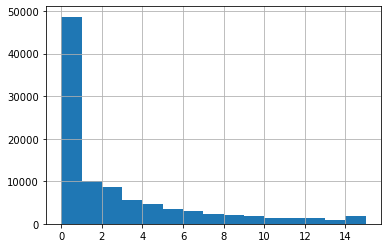

In [12]:
train_df['counts'].hist(bins = 15)

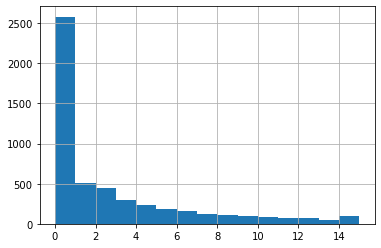

In [13]:
valid_df['counts'].hist(bins = 15)

In [14]:
print(train_df.ImageId.nunique(), 'unique images in train set')
print(valid_df.ImageId.nunique(),'unique images in test set')

68646 unique images in train set
3613 unique images in test set


In [86]:
class ShipDataset:
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)


In [16]:
#Create dataset
dataset_valid = ShipDataset(valid_df)

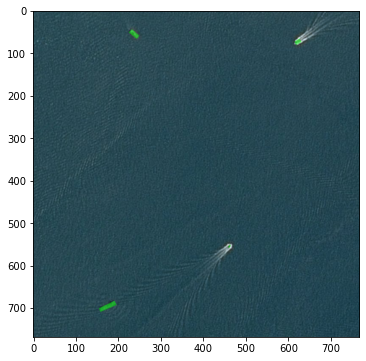

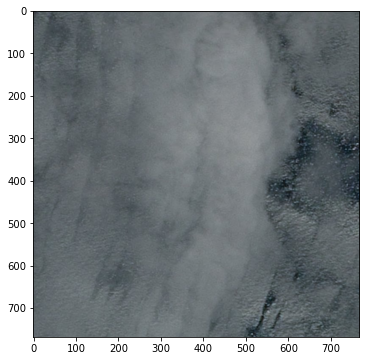

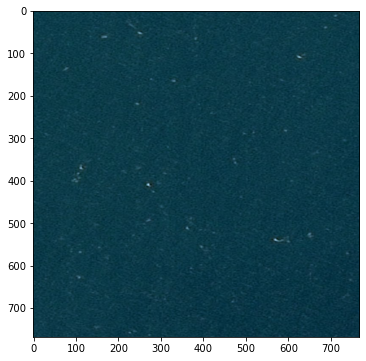

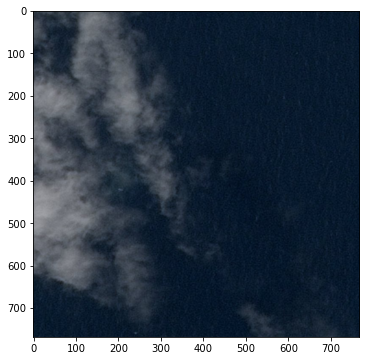

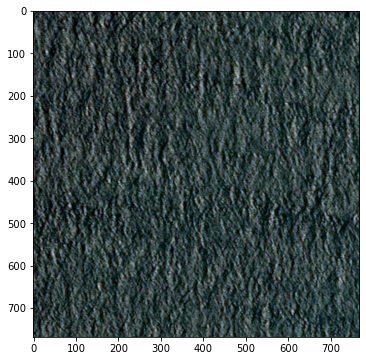

In [17]:
def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

    
def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

    

#To show image with its mask
for i in np.random.randint(0, dataset_valid.__len__(), 5):
    imshow(*dataset_valid[i])

In [20]:
def downsample(x, mask):
    if mask is not None:
        mask = mask[::2, ::2]
    return x[::2, ::2, :], mask
    
    
class RandomDownsample:
    def __init__(self, prob=0.5):
        self.prob = prob
    
    
    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            return downsample(x, mask)
        return x, mask



"""
    Implementation from  https://github.com/ternaus/robot-surgery-segmentation
"""

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask
    
class OneOf:
    def __init__(self, transforms, prob=0.5):
        self.transforms = transforms
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            t = random.choice(self.transforms)
            t.prob = 1.
            x, mask = t(x, mask)
        return x, mask

class OneOrOther:
    def __init__(self, first, second, prob=0.5):
        self.first = first
        first.prob = 1.
        self.second = second
        second.prob = 1.
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            x, mask = self.first(x, mask)
        else:
            x, mask = self.second(x, mask)
        return x, mask


class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask


class Transpose:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = img.transpose(1, 0, 2)
            if mask is not None:
                mask = mask.transpose(1, 0, 2)
        return img, mask


class RandomRotate90:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            img = np.rot90(img, factor)
            if mask is not None:
                mask = np.rot90(mask, factor)
        return img.copy(), mask.copy()


class Rotate:
    def __init__(self, limit=90, prob=0.5):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask


class Shift:
    def __init__(self, limit=4, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            limit = self.limit
            dx = round(random.uniform(-limit, limit))
            dy = round(random.uniform(-limit, limit))

            height, width, channel = img.shape
            y1 = limit + 1 + dy
            y2 = y1 + height
            x1 = limit + 1 + dx
            x2 = x1 + width

            img1 = cv2.copyMakeBorder(img, limit + 1, limit + 1, limit + 1, limit + 1,
                                      borderType=cv2.BORDER_REFLECT_101)
            img = img1[y1:y2, x1:x2, :]
            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit + 1, limit + 1, limit + 1, limit + 1,
                                          borderType=cv2.BORDER_REFLECT_101)
                mask = msk1[y1:y2, x1:x2, :]

        return img, mask


class ShiftScale:
    def __init__(self, limit=4, prob=.25):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        limit = self.limit
        if random.random() < self.prob:
            height, width, channel = img.shape
            assert (width == height)
            size0 = width
            size1 = width + 2 * limit
            size = round(random.uniform(size0, size1))

            dx = round(random.uniform(0, size1 - size))
            dy = round(random.uniform(0, size1 - size))

            y1 = dy
            y2 = y1 + size
            x1 = dx
            x2 = x1 + size

            img1 = cv2.copyMakeBorder(img, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
            img = (img1[y1:y2, x1:x2, :] if size == size0
            else cv2.resize(img1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
                mask = (msk1[y1:y2, x1:x2, :] if size == size0
                else cv2.resize(msk1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

        return img, mask


class ShiftScaleRotate:
    def __init__(self, shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, prob=0.5):
        self.shift_limit = shift_limit
        self.scale_limit = scale_limit
        self.rotate_limit = rotate_limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            height, width, channel = img.shape

            angle = random.uniform(-self.rotate_limit, self.rotate_limit)
            scale = random.uniform(1 - self.scale_limit, 1 + self.scale_limit)
            dx = round(random.uniform(-self.shift_limit, self.shift_limit)) * width
            dy = round(random.uniform(-self.shift_limit, self.shift_limit)) * height

            cc = math.cos(angle / 180 * math.pi) * scale
            ss = math.sin(angle / 180 * math.pi) * scale
            rotate_matrix = np.array([[cc, -ss], [ss, cc]])

            box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
            box1 = box0 - np.array([width / 2, height / 2])
            box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

            box0 = box0.astype(np.float32)
            box1 = box1.astype(np.float32)
            mat = cv2.getPerspectiveTransform(box0, box1)
            img = cv2.warpPerspective(img, mat, (width, height),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpPerspective(mask, mat, (width, height),
                                           flags=cv2.INTER_NEAREST,
                                           borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask
    
class RandomBrightness:
    def __init__(self, limit=0.1, prob=0.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[..., :3] = clip(alpha * img[..., :3], dtype, maxval)
        return img


class RandomContrast:
    def __init__(self, limit=.1, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[:, :, :3] = clip(alpha * img[:, :, :3] + gray, dtype, maxval)
        return img


### Show downsampled imagery

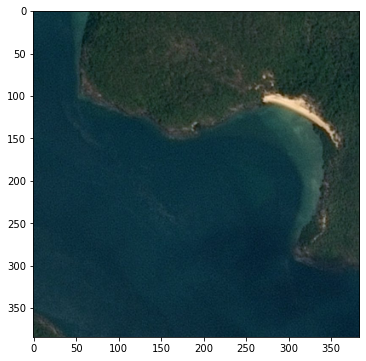

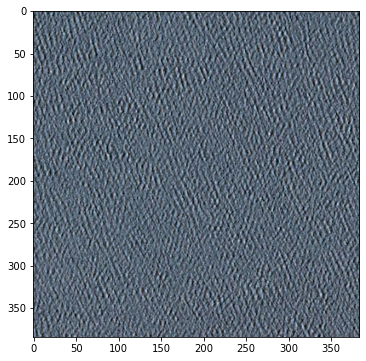

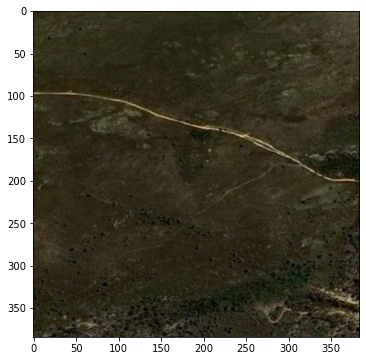

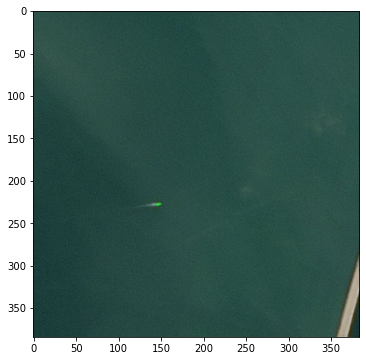

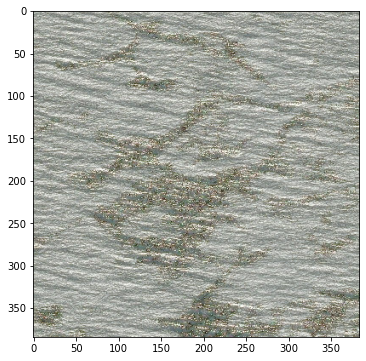

In [59]:
def downsample(x, mask):
    if mask is not None:
        mask = mask[:, ::2, ::2]
    return x[:, ::2, ::2 ], mask


def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    

# To show image with its mask
for i in np.random.randint(0, dataset_valid.__len__(), 5):
    imshow(*downsample(*dataset_valid[i]))
    

In [21]:
train_transform = DualCompose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomDownsample(prob=0.50),
        #ImageOnly(RandomBrightness()),
        #ImageOnly(RandomContrast()),
])

val_transform = DualCompose([
        CenterCrop((512,512,3)),
      ])

In [14]:
 class LossBinary:
    """
     Implementation from  https://github.com/ternaus/robot-surgery-segmentation
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [15]:
def validation(model: nn.Module, criterion, valid_loader):
    print("Validation on hold-out....")
    model.eval()
    losses = []
    jaccard = []
    for inputs, targets in valid_loader:
        inputs = variable(inputs, volatile=True)
        targets = variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data[0])
        jaccard += [get_jaccard(targets, (outputs > 0).float()).data[0]]

    valid_loss = np.mean(losses)  # type: float

    valid_jaccard = np.mean(jaccard)

    print('Valid loss: {:.5f}, jaccard: {:.5f}'.format(valid_loss, valid_jaccard))
    metrics = {'valid_loss': valid_loss, 'jaccard_loss': valid_jaccard}
    return metrics


def get_jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1).sum(dim = -1)
    union = y_true.sum(dim=-2).sum(dim=-1).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1).sum(dim = -1)

    return (intersection / (union - intersection + epsilon)).mean()

In [16]:
# sum helper functions
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    return x.cuda

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

In [33]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=1, fold=1):
    optimizer = init_optimizer(lr)
    #model = nn.DataParallel(model, device_ids=None)
    if torch.cuda.is_available():
        model.cuda()
       
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))


    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    valid_losses = []
    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  BATCH_SIZE)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                print(targets.shape)
                inputs, targets = variable(inputs), variable(targets)
                outputs = model(inputs, targets)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.data[0])
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader)
            write_event(log, step, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return

In [22]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

train_loader = make_loader(train_df, batch_size =  BATCH_SIZE, shuffle=True, transform=train_transform)
valid_loader = make_loader(valid_df, batch_size = int(BATCH_SIZE / 2), transform=None)

NameError: name 'ShipDataset' is not defined

# The Model

In [26]:
# From: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                            momentum=0.9, weight_decay=0.0005)
#
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

# Train

In the following section we will train the model. Because this is a computationally-expensive task, we must be sure that all parameters are well-chosen and the procedure is understood.

### Test transforms, etc.

In [139]:
masks = pd.concat((filtered_masks, null_masks))
masks.shape[0] == filtered_masks.shape[0] * 2
masks.head()

,ImageId,EncodedPixels
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...


In [23]:
def downsample(x, mask):
    if mask is not None:
        mask = mask[::2, ::2, :]
    return x[::2, ::2, :], mask
    
    
class RandomDownsample:
    def __init__(self, prob=0.5):
        self.prob = prob
    
    
    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            return downsample(x, mask)
        return x, mask


train_transform = DualCompose([
        RandomDownsample(prob=1.0),
        #ImageOnly(RandomBrightness()),
        #ImageOnly(RandomContrast()),
])

val_transform = DualCompose([
        CenterCrop((512,512,3)),
      ])


class ShipDataset:
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)
        
        
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

    
train_loader = make_loader(train_df, batch_size =  BATCH_SIZE, shuffle=True, transform=train_transform)
valid_loader = make_loader(valid_df, batch_size = int(BATCH_SIZE / 2), transform=None)

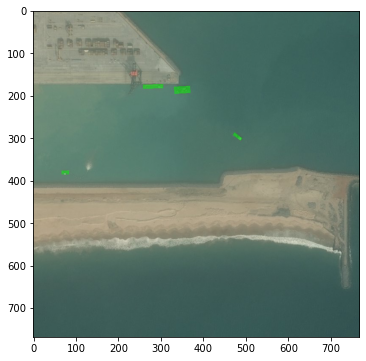

In [172]:
imshow(*ShipDataset(masks, transform=train_transform, mode='train')[1])

In [34]:
# Train the model 
train(init_optimizer=lambda lr: Adam(model.parameters(), lr=lr),
        lr = 1e-4,
        n_epochs = 1,
        model=model,
        criterion=LossBinary(jaccard_weight=5),
        train_loader=train_loader,
        valid_loader=valid_loader,
        validation=validation,
        )




  0%|          | 0/68656 [00:00<?, ?it/s]


Epoch 1, lr 0.0001:   0%|          | 0/68656 [00:00<?, ?it/s]

torch.Size([16, 1, 384, 384])


TypeError: 'builtin_function_or_method' object is not iterable